In [48]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from mqt.predictor.ml.helper import create_feature_dict

from qiskit import QuantumCircuit

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

mpl.rcParams['font.family'] = 'serif'
directory = '/home/ubuntu/mqt/mqt-predictor-fork/evaluations/supervised_ml_models/experiments_new'
# labels / output vector
labels = ['number_of_gates', 'depth', 'entanglement_ratio', 'critical_depth', 'parallelism']


# Import the training circuits and scores

In [49]:
# dictionary to store all circuits and outputs
circuits = {}
outputs = {}

# walk through all subdirectories
for subdir, dirs, files in os.walk(directory):
    # get the filename from the subdir name
    filename = os.path.basename(subdir)
    # find the .qasm file in current subdir
    qasm_files = glob.glob(os.path.join(subdir, '*.qasm'))
    # find the .out file in current subdir
    out_files = glob.glob(os.path.join(subdir, '*.out'))
    # if a .qasm file and a .out file are found
    if qasm_files and out_files:
        # load circuit and add it to the dict
        circuits[filename] = QuantumCircuit.from_qasm_file(qasm_files[0])
        # load output and add it to the dict
        with open(out_files[0], 'r') as f:
            outputs[filename] = np.genfromtxt(f)

print(len(circuits), 'circuits')
print(len(outputs), 'outputs')
#print(outputs[filename])

175 circuits
175 outputs


# Extract the fittest (non-dominated) children for each circuit

In [50]:
def is_dominated(child, population):
    # Check if any member of the population dominates the child
    for i, child_val in enumerate(child):
        for individual_val in population:
            if individual_val[i] < child_val:
                return True
    return False

In [51]:
fittest_children = {}
for name, output in outputs.items():
    # Convert your 2D array to a list of lists for easier processing
    population = output.tolist()

    # Filter out dominated individuals
    non_dominated_population = [child for child in population if not is_dominated(child, population)]

    # If there are NO non-dominated individuals, select the one with
    # the lowest number of gates, depth, entanglement ratio, critical depth, parallelism
    if non_dominated_population:
        print('non dominated child', non_dominated_population[0])
        fittest_children[name] = non_dominated_population[0]
    else:
        # Convert population to a numpy array
        population_np = np.array(population)

        # Create a list of keys for lexsort
        # Reverse the order of the keys because lexsort sorts by the last key first
        keys = [population_np[:, i] for i in reversed(range(population_np.shape[1]))]

        # Get the indices that would sort the population in increasing order looking at
        # number of gates, depth, entanglement ratio, critical depth, parallelism
        indices = np.lexsort(keys)

        # Get the index of the first (smallest) element
        min_index = indices[0]

        # Get the corresponding element from the population
        alternative_child = population[min_index]

        print('alternative child  ', alternative_child)
        fittest_children[name] = alternative_child

print(len(fittest_children))

non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
alternative child   [5.0, 2.0, 0.0, 0.0, 0.75]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
alternative child   [3.0, 1.0, 0.0, 0.0, 1.0]
alternative child   [5.0, 2.0, 0.0, 0.0, 0.75]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
alternative child   [5.0, 2.0, 0.0, 0.0, 0.75]
alternative child   [2.0, 1.0, 0.0, 0.0, 1.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
alternative child   [2.0, 1.0, 0.0, 0.0, 1.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
alternative child   [2.0, 1.0, 0.0, 0.0, 1.0]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
alternative child   [8.0, 4.0, 0.0, 0.0, 0.5]
non dominated child [1.0, 1.0, 0.0, 0.0, 0.0]
non dominated child [1.0, 1.0, 

# Prepare the feature vectors

In [52]:
X, y = [], []
for circ_name, child_name in zip(circuits, fittest_children):
    assert circ_name == child_name
    X.append(list(create_feature_dict(circuits[circ_name]).values()))
    y.append(fittest_children[child_name])
X = np.array(X)
y = np.array(y)

print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (175, 52) y.shape: (175, 5)


# Find best hyperparameters

In [26]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Assuming y is a 2D array with each column being a separate output
models = []
best_params_list = []

for i in range(y.shape[1]):
    # Initialize the regressor
    rf = RandomForestRegressor()

    # Initialize the GridSearchCV
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV to your data
    grid_search.fit(X, y[:, i])

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f'Best parameters for output {i}: {best_params}')

    # Train the model with the best parameters
    rf_best = RandomForestRegressor(**best_params)
    rf_best.fit(X, y[:, i])

    # Store the model and best parameters
    models.append(rf_best)
    best_params_list.append(best_params)

Best parameters for output 0: {'bootstrap': True, 'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for output 1: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best parameters for output 2: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best parameters for output 3: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best parameters for output 4: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


# Train the model with best hyper parameters

In [53]:
# If not defined before, define models and best_params_list
try:
    print(best_params_list)
except NameError:
    best_params = [
        {'bootstrap': True, 'max_depth': 40,   'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, # number of gates
        {'bootstrap': True, 'max_depth': 30,   'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}, # depth
        {'bootstrap': True, 'max_depth': 30,   'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}, # entanglement ratio
        {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5,  'n_estimators': 500}, # critical depth
        {'bootstrap': True, 'max_depth': 20,   'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}  # parallelism
    ]
    models = []

if not models:
    for i in range(y.shape[1]):
            rf = RandomForestRegressor(**best_params[i])
            rf.fit(X, y[:, i])
            models.append(rf)

for i, model in enumerate(models):
    print('Score:', model.score(X, y[:, i]))

Score: 0.4857352105290974
Score: 0.8321051972442117
Score: 0.9068875491767078
Score: 0.6029825179998654
Score: 0.7513859588263668


# Evaluate the model

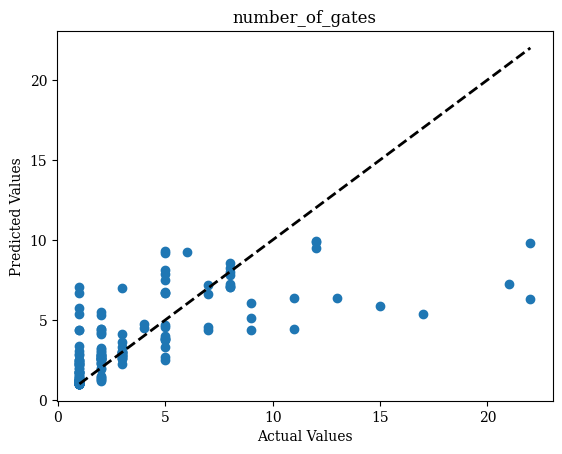

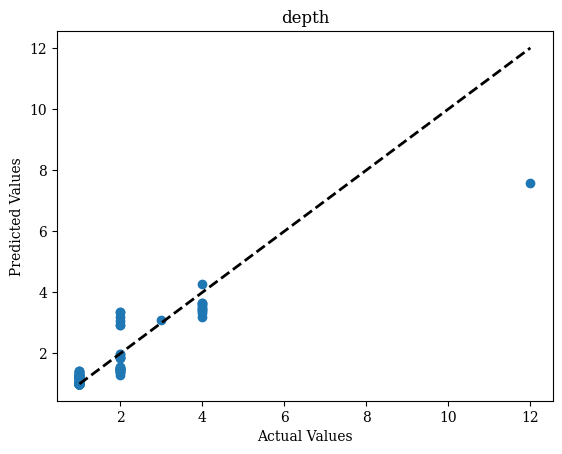

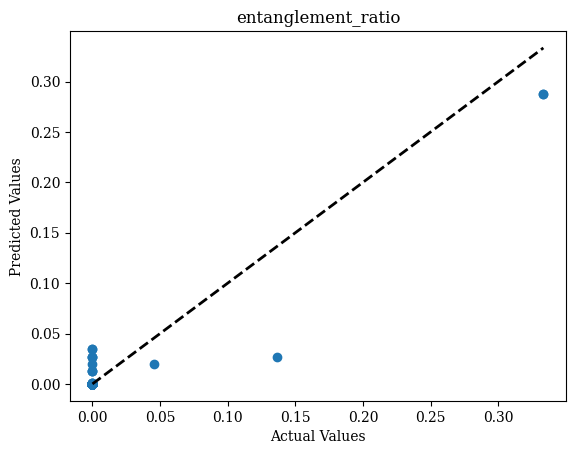

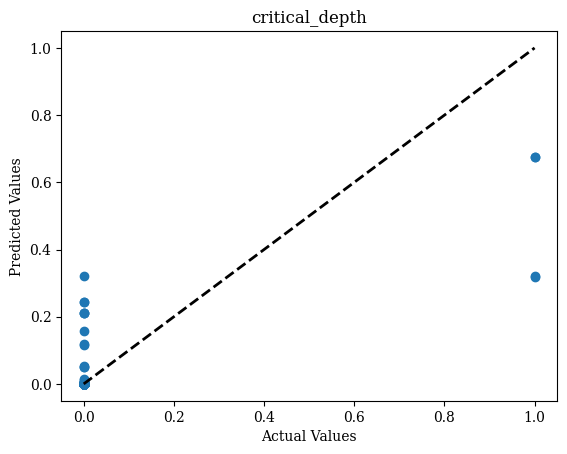

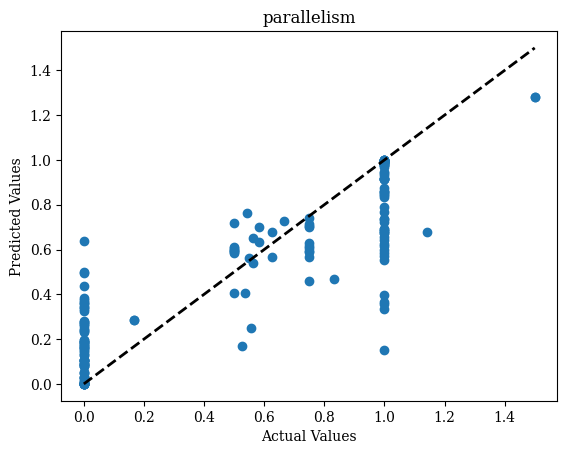

In [54]:
# Predict the output for input data
y_pred = [model.predict(X) for model in models]

# Create a scatter plot of predicted vs actual values for each output
for i in range(y.shape[1]):
    plt.figure(i)
    plt.scatter(y[:, i], y_pred[i])
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(labels[i])

    # Draw a diagonal line for perfect prediction
    plt.plot([y[:, i].min(), y[:, i].max()], [y[:, i].min(), y[:, i].max()], 'k--', lw=2)

plt.show()

# Export the model

In [55]:
# Assuming models is a list of your trained models
for i, model in enumerate(models):
    # Define the input data type
    initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]

    # Convert the model to ONNX
    onnx_model = convert_sklearn(model, initial_types=initial_type)

    # Save the model
    with open(f"q20_ga_{labels[i]}.onnx", "wb") as f:
        f.write(onnx_model.SerializeToString())